In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import json
from tqdm import tqdm_notebook
from IPython.display import HTML
import warnings
pd.set_option('max_columns', 100)
warnings.filterwarnings("ignore")
%matplotlib inline 
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

In [53]:
from plotly.offline import iplot
from plotly import tools
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)

In [2]:
!ls -GFlash ./data/

total 8372248
      0 drwxr-xr-x@ 7 lambda  staff   224B 11  2 12:01 ./
      0 drwxr-xr-x  7 lambda  staff   224B 11 11 17:28 ../
     24 -rw-rw-r--@ 1 lambda  staff    11K 10 21 20:56 sample_submission.csv
    800 -rw-rw-r--@ 1 lambda  staff   399K 10 21 20:56 specs.csv
 777984 -rw-rw-r--@ 1 lambda  staff   380M 10 21 20:56 test.csv
7591240 -rw-rw-r--@ 1 lambda  staff   3.6G 10 21 20:57 train.csv
   2200 -rw-rw-r--@ 1 lambda  staff   1.1M 10 21 21:02 train_labels.csv


## Data Description

- Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.
- The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt). 
- Each application install is represented by an installation_id. 
- This will typically correspond to one child, but you should expect noise from issues such as shared devices. 
- In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. 
- Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

## Reda Data

In [62]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True


            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [3]:
train = pd.read_csv('./data//train.csv')
train_labels = pd.read_csv('./data/train_labels.csv')
test = pd.read_csv('./data/test.csv')
specs = pd.read_csv('./data/specs.csv')
ss = pd.read_csv('./data/sample_submission.csv')

In [63]:
train, _ = reduce_mem_usage(train)

Memory usage of properties dataframe is : 951.7782440185547  MB
******************************
Column:  event_count
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  event_code
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  game_time
dtype before:  int64
dtype after:  uint32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  778.7276763916016  MB
This is  81.81818415009079 % of the initial size


In [67]:
import gc
gc.collect()

19665

In [4]:
print(f'Train data has shape: {train.shape}')
print(f'Test data has shape: {test.shape}')

Train data has shape: (11341042, 11)
Test data has shape: (1156414, 11)


In [69]:
train_ = train.sample(1000000) #sample 1M observations

In [5]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [22]:
# train[train.installation_id=='02490b06'].to_excel('observation.xls',index=False,encoding='utf_8_sig')

## Label Distribution

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved


即正确率 100% 为 group 3；正确率 ~50% 为 group 2；没完成为 group 0；group 1 变动最大。

In [37]:
train[(train.installation_id=='0006a69f')&(train.title=='Mushroom Sorter (Assessment)')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2185,3bfd1a65,901acc108f55a5a1,2019-08-06T05:22:01.344Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2186,db02c830,901acc108f55a5a1,2019-08-06T05:22:01.400Z,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2187,a1e4395d,901acc108f55a5a1,2019-08-06T05:22:01.403Z,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2188,a52b92d5,901acc108f55a5a1,2019-08-06T05:22:05.242Z,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2189,a1e4395d,901acc108f55a5a1,2019-08-06T05:22:05.244Z,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
...,...,...,...,...,...,...,...,...,...,...,...
3734,25fa8af4,9501794defd84e4d,2019-08-06T20:35:16.846Z,"{""correct"":true,""stumps"":[2,3,5],""event_count""...",0006a69f,38,4100,23043,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
3735,9d29771f,9501794defd84e4d,2019-08-06T20:35:16.849Z,"{""description"":""Alright! This one is the littl...",0006a69f,39,3021,23043,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
3736,c74f40cd,9501794defd84e4d,2019-08-06T20:35:21.026Z,"{""description"":""Alright! This one is the littl...",0006a69f,40,3121,27226,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
3737,6c930e6e,9501794defd84e4d,2019-08-06T20:35:21.654Z,"{""duration"":22409,""misses"":1,""event_count"":41,...",0006a69f,41,2030,27842,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [38]:
# train[(train.installation_id=='0006a69f')&(train.title=='Mushroom Sorter (Assessment)')].to_excel('observation.xls',index=False,encoding='utf_8_sig')

In [6]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


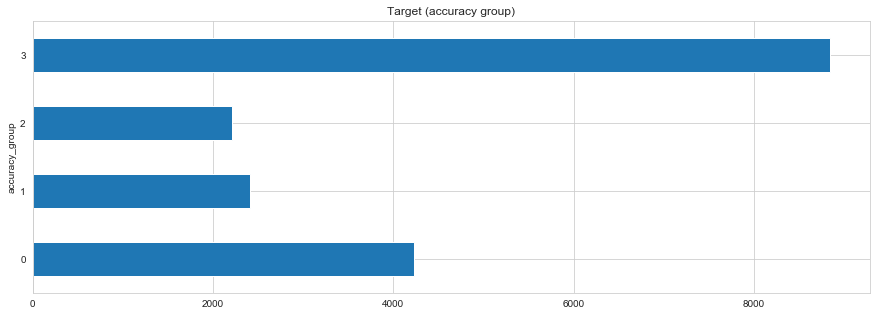

In [8]:
train_labels.groupby('accuracy_group')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Target (accuracy group)')
plt.show()

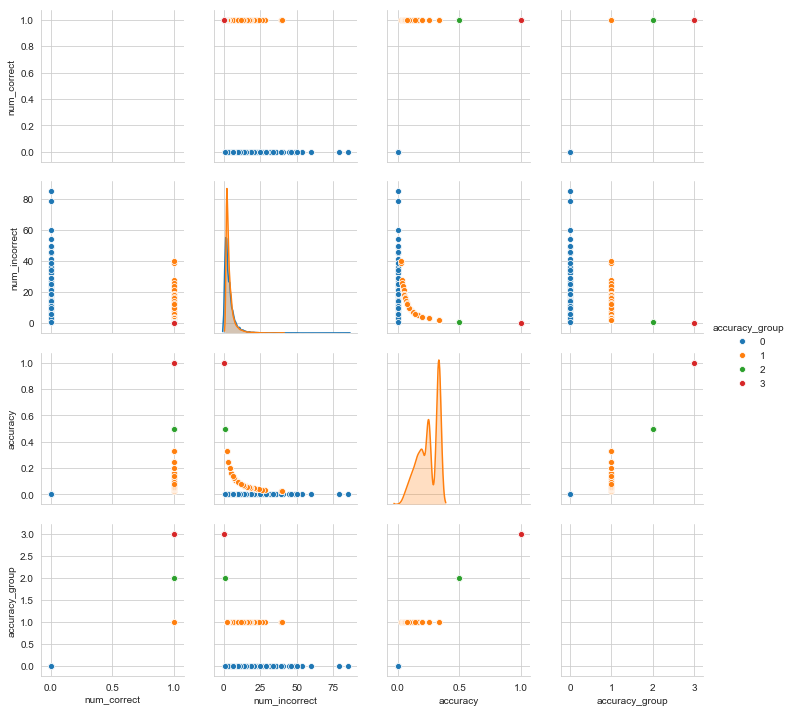

In [11]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

In [41]:
train_labels.title.unique()

array(['Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)',
       'Cart Balancer (Assessment)'], dtype=object)

In [52]:
#temp=df.drop_duplicates('GameId', keep='last')
temp_df = train_labels.groupby(["title","accuracy_group"])["accuracy_group"].agg(["count"]).reset_index()
temp_df.columns = ["title","accuracy_group", "Count"]
#temp_df.Country = temp_df[temp_df.Country != 'United Kingdom']

fig = px.scatter(temp_df, x="accuracy_group", y="title", color="accuracy_group", size="Count")
layout = go.Layout(
    title=go.layout.Title(
        text="Accuracy group in each Assesments",
        x=0.55
    ),
    font=dict(size=14),
    width=800,
    height=600,
    showlegend=False
)
fig.update_layout(layout)
fig.show()

### Success rate in each group

In [55]:
Success_Rate_1=pd.DataFrame()
Success_Rate_2=pd.DataFrame()
Success_Rate_3=pd.DataFrame()
Success_Rate_4=pd.DataFrame()
Success_Rate_5=pd.DataFrame()
Mushroom_Sorter=train_labels.loc[train_labels['title'] == 'Mushroom Sorter (Assessment)']
Success_Rate_1['Type']=Mushroom_Sorter.num_correct.value_counts().index
Success_Rate_1['Count']=Mushroom_Sorter.num_correct.value_counts().values
Bird_Measurer=train_labels.loc[train_labels['title'] ==  'Bird Measurer (Assessment)']
Success_Rate_2['Type']=Bird_Measurer.num_correct.value_counts().index
Success_Rate_2['Count']=Bird_Measurer.num_correct.value_counts().values
Cauldron_Filler=train_labels.loc[train_labels['title'] == 'Cauldron Filler (Assessment)']
Success_Rate_3['Type']=Cauldron_Filler.num_correct.value_counts().index
Success_Rate_3['Count']=Cauldron_Filler.num_correct.value_counts().values
Chest_Sorter=train_labels.loc[train_labels['title'] == 'Chest Sorter (Assessment)']
Success_Rate_4['Type']=Chest_Sorter.num_correct.value_counts().index
Success_Rate_4['Count']=Chest_Sorter.num_correct.value_counts().values
Cart_Balancer=train_labels.loc[train_labels['title'] == 'Cart Balancer (Assessment)']
Success_Rate_5['Type']=Cart_Balancer.num_correct.value_counts().index
Success_Rate_5['Count']=Cart_Balancer.num_correct.value_counts().values

In [ ]:
from plotly.offline import iplot
from plotly import tools
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)

In [59]:
labels = [0,1]

fig = make_subplots(3, 2, specs=[[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Mushroom Sorter', 'Bird Measurer','Cauldron Filler','Chest Sorter','Cart Balancer'])
fig.add_trace(go.Pie(labels=Success_Rate_1['Type'], values=Success_Rate_1['Count'], scalegroup='one',
                     name="Success Rate"), 1, 1)
fig.add_trace(go.Pie(labels=Success_Rate_2['Type'], values=Success_Rate_2['Count'], scalegroup='one',
                     name="Success Rate"), 1, 2)
fig.add_trace(go.Pie(labels=Success_Rate_3['Type'], values=Success_Rate_3['Count'], scalegroup='one',
                     name="Success Rate"), 2, 1)
fig.add_trace(go.Pie(labels=Success_Rate_4['Type'], values=Success_Rate_4['Count'], scalegroup='one',
                     name="Success Rate"), 2, 2)
fig.add_trace(go.Pie(labels=Success_Rate_5['Type'], values=Success_Rate_5['Count'], scalegroup='one',
                     name="Success Rate"), 3, 1)

fig.update_layout(title_text='Success Rate of Each Group')
fig.show()

## Train / Test

- `event_id` - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- `game_session` - Randomly generated unique identifier grouping events within a single game or video play session.
- `timestamp` - Client-generated datetime
- `event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise - fields are determined by the event type.
- `installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- `event_count` - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- `event_code` - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- `game_time` - Time in milliseconds since the start of the game session. Extracted from event_data.
- `title` - Title of the game or video.
- `type` - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- `world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [12]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [51]:
print(f"train installation id: {train.installation_id.nunique()}")
print(f"test installation id: {test.installation_id.nunique()}")
print(f"train event id: {train.event_id.nunique()}")
print(f"test event id: {test.event_id.nunique()}")
print(f"specs event id: {specs.event_id.nunique()}")

train installation id: 17000
test installation id: 1000
train event id: 384
test event id: 365
specs event id: 386


In [32]:
test.query('installation_id=="00abaee7"').head(20)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES
5,f93fc684,a022c3f60ba547e7,2019-09-10T16:54:14.338Z,"{""coordinates"":{""x"":515,""y"":697,""stage_width"":...",00abaee7,2,4010,2232,Chow Time,Game,CRYSTALCAVES
6,7ec0c298,a022c3f60ba547e7,2019-09-10T16:54:16.553Z,"{""description"":""It's Chow Time! We have some V...",00abaee7,3,3010,4445,Chow Time,Game,CRYSTALCAVES
7,0d1da71f,a022c3f60ba547e7,2019-09-10T16:54:23.364Z,"{""description"":""It's Chow Time! We have some V...",00abaee7,4,3110,11251,Chow Time,Game,CRYSTALCAVES
8,63f13dd7,a022c3f60ba547e7,2019-09-10T16:54:23.365Z,"{""dinosaur"":""stacey"",""diet"":""herbivore"",""targe...",00abaee7,5,2020,11251,Chow Time,Game,CRYSTALCAVES
9,7372e1a5,a022c3f60ba547e7,2019-09-10T16:54:25.029Z,"{""coordinates"":{""x"":901,""y"":449,""stage_width"":...",00abaee7,6,4070,12929,Chow Time,Game,CRYSTALCAVES


In [33]:
test.query('installation_id=="00abaee7"').tail(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
863,832735e1,ee2200d38a57537b,2019-09-12T13:51:37.371Z,"{""description"":""There we have it, folks. Some ...",00abaee7,132,3010,178304,Dino Dive,Game,MAGMAPEAK
864,ab3136ba,ee2200d38a57537b,2019-09-12T13:51:44.003Z,"{""description"":""There we have it, folks. Some ...",00abaee7,133,3110,184938,Dino Dive,Game,MAGMAPEAK
865,832735e1,ee2200d38a57537b,2019-09-12T13:51:47.877Z,"{""description"":""Okay, team, we have to win fou...",00abaee7,134,3010,188805,Dino Dive,Game,MAGMAPEAK
866,7961e599,ee2200d38a57537b,2019-09-12T13:51:47.878Z,"{""target_water_level"":3,""round"":5,""event_count...",00abaee7,135,2020,188805,Dino Dive,Game,MAGMAPEAK
867,90d848e0,348d7f09f96af313,2019-09-12T13:52:12.193Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


### Missing values

In [54]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [55]:
missing_data(train)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
Total,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0
Types,object,object,object,object,object,int64,int64,int64,object,object,object


In [56]:
missing_data(test)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
Total,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0
Types,object,object,object,object,object,int64,int64,int64,object,object,object


In [68]:
missing_data(specs)

,event_id,info,args
Total,0,0,0
Percent,0,0,0
Types,object,object,object


### `event_id` & `game_session`

16 进制

`game_session` 与 `event_count` 相对应。

In [44]:
train['event_id'].nunique()

384

In [45]:
train['game_session'].nunique()

303319

In [52]:
# unique identifier grouping events within a single game
train['game_session'].nunique() == train[train.event_count==1].shape[0]

True

In [14]:
train['event_id_as_int'] = train['event_id'].apply(lambda x: int(x, 16))
train['game_session_as_int'] = train['game_session'].apply(lambda x: int(x, 16))

### `timestamp`

In [69]:
def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['weekday_name'] = df['timestamp'].dt.weekday_name
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_month_start'] = df['timestamp'].dt.is_month_start
    return df

In [70]:
train = extract_time_features(train)
test = extract_time_features(test)

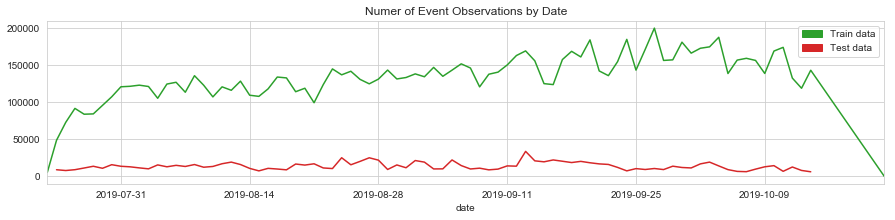

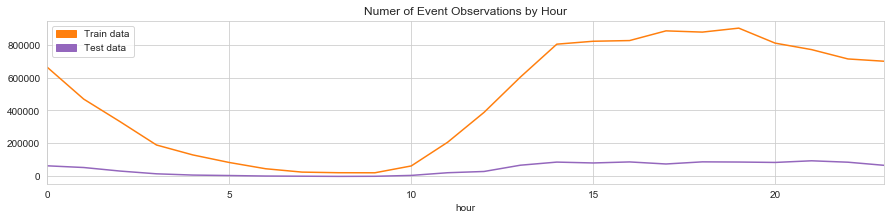

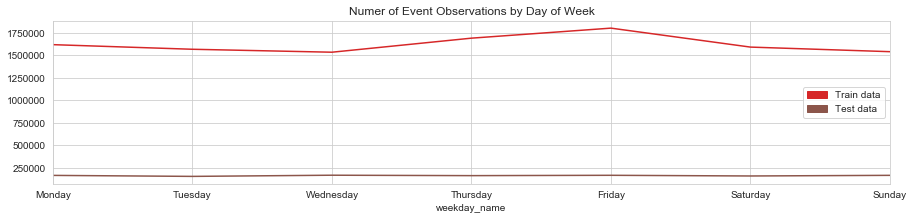

In [77]:
train.groupby('date')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Date',
         color=my_pal[2])
test.groupby('date')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Date',
         color=my_pal[3])
train_patch = mpatches.Patch(color=my_pal[2], label='Train data')
test_patch = mpatches.Patch(color=my_pal[3], label='Test data')
plt.legend(handles=[train_patch, test_patch])
plt.show()

train.groupby('hour')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Hour',
         color=my_pal[1])
test.groupby('hour')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Hour',
         color=my_pal[4])
train_patch = mpatches.Patch(color=my_pal[1], label='Train data')
test_patch = mpatches.Patch(color=my_pal[4], label='Test data')
plt.legend(handles=[train_patch, test_patch])
plt.show()

train.groupby('weekday_name')['event_id'] \
    .agg('count').T[['Monday','Tuesday','Wednesday',
                     'Thursday','Friday','Saturday',
                     'Sunday']].T.plot(figsize=(15, 3),
                                       title='Numer of Event Observations by Day of Week',
                                       color=my_pal[3])
test.groupby('weekday_name')['event_id'] \
    .agg('count').T[['Monday','Tuesday','Wednesday',
                     'Thursday','Friday','Saturday',
                     'Sunday']].T.plot(figsize=(15, 3),
                                       title='Numer of Event Observations by Day of Week',
                                       color=my_pal[5])
train_patch = mpatches.Patch(color=my_pal[3], label='Train data')
test_patch = mpatches.Patch(color=my_pal[5], label='Test data')
plt.legend(handles=[train_patch, test_patch])
plt.show()

### `event_data`

In [20]:
print(train['event_data'][4])
print(train['event_data'][5])

{"description":"Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!","identifier":"Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape","media_type":"audio","duration":6919,"event_count":3,"game_time":6972,"event_code":3110}
{"coordinates":{"x":583,"y":605,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":9991,"event_code":4070}


In [74]:
%%time
extracted_event_data = pd.io.json.json_normalize(train_.event_data.apply(json.loads))

CPU times: user 1min 8s, sys: 2.89 s, total: 1min 11s
Wall time: 1min 12s


In [75]:
extracted_event_data.head(10)

,object,source,event_count,game_time,event_code,layout.left.chickens,layout.left.pig,layout.right.chickens,layout.right.pig,coordinates.x,coordinates.y,coordinates.stage_width,coordinates.stage_height,has_toy,bowl_id,scale_contents,position,round,level,bottles,bottle.amount,bottle.color,rocket,height,duration,launched,size,sand,filled,description,identifier,media_type,options,animals,round_target.size,round_target.type,round_target.animal,cloud,cloud_size,total_duration,previous_jars,weight,resources,destination,correct,pillars,left,right,nest,layout.row1,...,dinosaur_weight,dinosaur_count,growth,houses,container_type,diet,weights,gate.row,gate.column,gate.side,stage_number,group,object_type,stumps,water_level,target_size,location,scale_weights,hat,caterpillar,hats,buckets,buckets_placed,version,bucket,time_played,distance,target_distances,toy_earned,cauldron,holes,hole_position,total_bowls,bowls,shells,session_duration,exit_type,target_water_level,tutorial_step,bird_height,dwell_time,target_bucket,round_prompt,max_position,end_position,hats_placed,molds,tape_length,bug_length,chests
0,pig,resources,41,50700.0,4030,5.0,False,5.0,False,462.0,409.0,1015.0,762.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,179,219493.0,4045,NaN,NaN,NaN,NaN,417.0,400.0,1014.0,541.0,False,2.0,"[empty, empty]",4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,resources,7,26007.0,4030,NaN,NaN,NaN,NaN,224.0,480.0,1014.0,541.0,True,1.0,"[empty, empty]",1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,610,655044.0,4070,NaN,NaN,NaN,NaN,1398.0,311.0,2028.0,1082.0,NaN,NaN,NaN,NaN,55.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,383,468475.0,4070,NaN,NaN,NaN,NaN,139.0,326.0,1015.0,406.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,55,54363.0,4070,NaN,NaN,NaN,NaN,895.0,421.0,1014.0,468.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,6,34,38826.0,4030,NaN,NaN,NaN,NaN,308.0,507.0,1015.0,762.0,NaN,NaN,NaN,NaN,2.0,NaN,"[{'color': 'blue', 'amount': 2}, {'color': 'bl...",2.0,orange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [76]:
missing_data(extracted_event_data)

,object,source,event_count,game_time,event_code,layout.left.chickens,layout.left.pig,layout.right.chickens,layout.right.pig,coordinates.x,coordinates.y,coordinates.stage_width,coordinates.stage_height,has_toy,bowl_id,scale_contents,position,round,level,bottles,bottle.amount,bottle.color,rocket,height,duration,launched,size,sand,filled,description,identifier,media_type,options,animals,round_target.size,round_target.type,round_target.animal,cloud,cloud_size,total_duration,previous_jars,weight,resources,destination,correct,pillars,left,right,nest,layout.row1,...,dinosaur_weight,dinosaur_count,growth,houses,container_type,diet,weights,gate.row,gate.column,gate.side,stage_number,group,object_type,stumps,water_level,target_size,location,scale_weights,hat,caterpillar,hats,buckets,buckets_placed,version,bucket,time_played,distance,target_distances,toy_earned,cauldron,holes,hole_position,total_bowls,bowls,shells,session_duration,exit_type,target_water_level,tutorial_step,bird_height,dwell_time,target_bucket,round_prompt,max_position,end_position,hats_placed,molds,tape_length,bug_length,chests
Total,979863,863327,0,16190,0,972957,972957,972957,972957,486536,486536,486536,486536,989461,987658,975914,964651,401449,910357,955297,955362,955362,981530,983977,667461,991116,931563,990536,987099,660259,665835,665835,991866,991866,984150,984150,984150,985623,985623,831244,992993,941715,970366,991950,929512,991004,987443,987443,996335,992210,...,993526,993511,996298,997669,999198,996681,996172,996225,996225,996225,999267,997805,996120,995800,987769,998315,993771,988891,995375,993914,995304,994517,994743,989440,995154,999244,996705,996314,999374,998455,995313,996494,998970,998970,998819,998937,999731,998827,999347,997569,999928,998740,999389,999799,999799,999298,999841,999966,999966,999982
Percent,97.9863,86.3327,0,1.619,0,97.2957,97.2957,97.2957,97.2957,48.6536,48.6536,48.6536,48.6536,98.9461,98.7658,97.5914,96.4651,40.1449,91.0357,95.5297,95.5362,95.5362,98.153,98.3977,66.7461,99.1116,93.1563,99.0536,98.7099,66.0259,66.5835,66.5835,99.1866,99.1866,98.415,98.415,98.415,98.5623,98.5623,83.1244,99.2993,94.1715,97.0366,99.195,92.9512,99.1004,98.7443,98.7443,99.6335,99.221,...,99.3526,99.3511,99.6298,99.7669,99.9198,99.6681,99.6172,99.6225,99.6225,99.6225,99.9267,99.7805,99.612,99.58,98.7769,99.8315,99.3771,98.8891,99.5375,99.3914,99.5304,99.4517,99.4743,98.944,99.5154,99.9244,99.6705,99.6314,99.9374,99.8455,99.5313,99.6494,99.897,99.897,99.8819,99.8937,99.9731,99.8827,99.9347,99.7569,99.9928,99.874,99.9389,99.9799,99.9799,99.9298,99.9841,99.9966,99.9966,99.9982
Types,object,object,int64,float64,int64,float64,object,float64,object,float64,float64,float64,float64,object,float64,object,float64,float64,float64,object,float64,object,float64,float64,float64,object,float64,float64,object,object,object,object,object,object,float64,object,object,object,float64,float64,object,float64,object,object,object,object,object,object,float64,object,...,float64,float64,object,object,object,object,float64,float64,float64,object,float64,float64,object,object,float64,float64,object,float64,float64,object,object,object,object,object,float64,float64,float64,object,object,float64,object,float64,float64,object,object,float64,object,float64,float64,float64,float64,float64,object,float64,float64,object,object,float64,float64,object


Text(0,0.5,'Features')

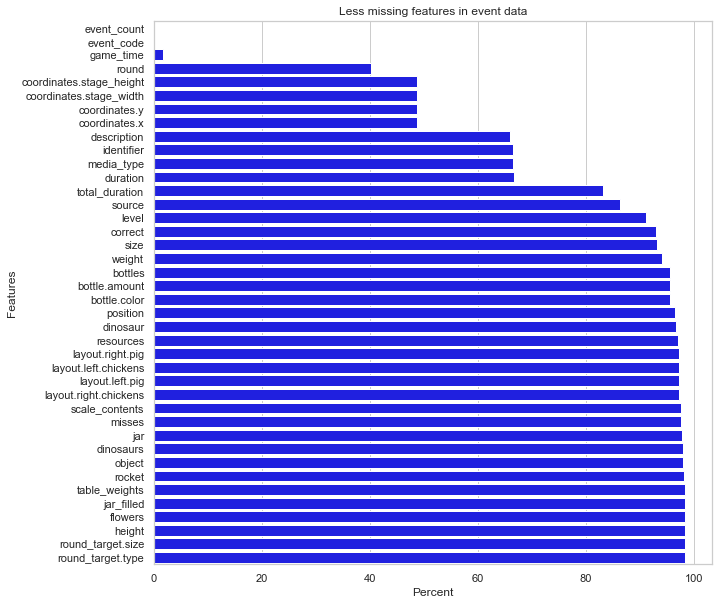

In [83]:
plt.figure(figsize=(10, 10))
sns.set(style='whitegrid')
ax = sns.barplot(x='Percent', y='index', data=missing_data(extracted_event_data).T.sort_values(['Total'], ascending=True).reset_index().head(40), color='blue')
plt.title('Less missing features in event data')
plt.ylabel('Features')

### `installation_id`

**important - predictions are grouped by these**

In [21]:
train['installation_id'].nunique()

17000

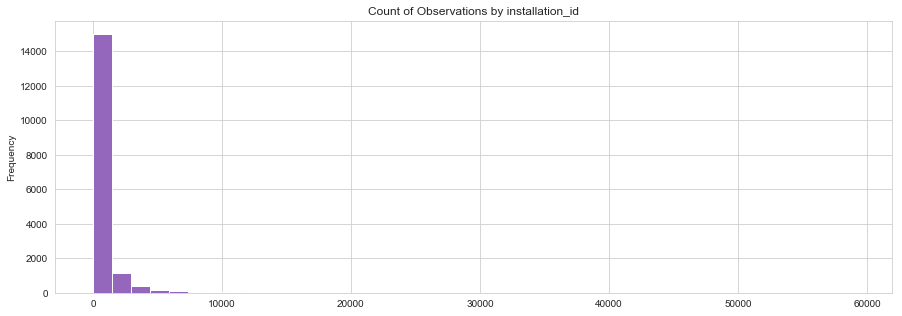

In [22]:
train.groupby('installation_id') \
    .count()['event_id'] \
    .plot(kind='hist',
          bins=40,
          color=my_pal[4],
          figsize=(15, 5),
         title='Count of Observations by installation_id')
plt.show()

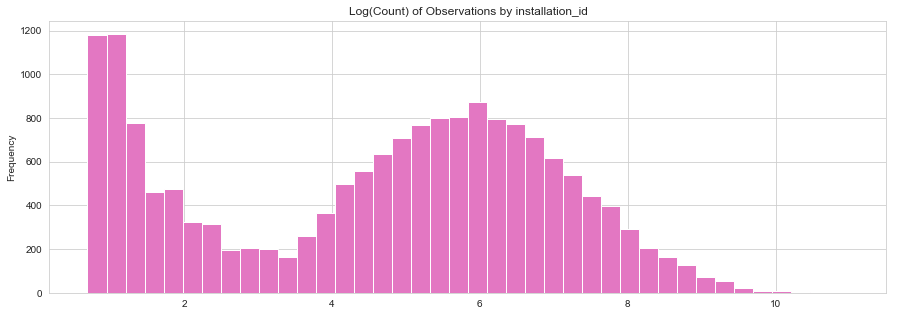

In [23]:
## take a log transform

train.groupby('installation_id') \
    .count()['event_id'] \
    .apply(np.log1p) \
    .plot(kind='hist',
          bins=40,
          color=my_pal[6],
         figsize=(15, 5),
         title='Log(Count) of Observations by installation_id')
plt.show()

In [24]:
train.groupby('installation_id') \
    .count()['event_id'].sort_values(ascending=False).head(5)

installation_id
f1c21eda    58988
4d7d3d97    32749
d25338cb    31826
cff5a334    30918
c9ea32e9    30402
Name: event_id, dtype: int64

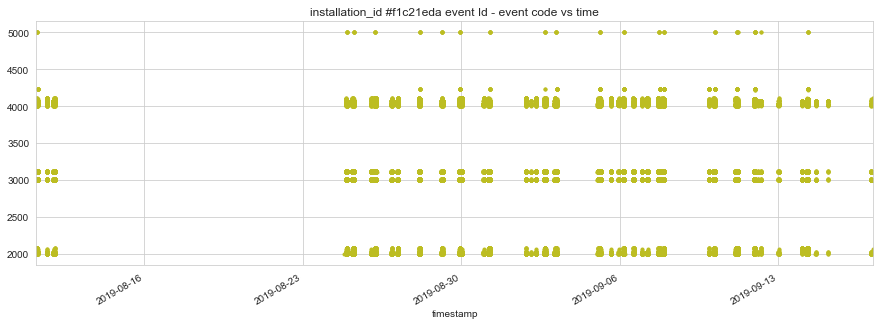

In [25]:
train.query('installation_id == "f1c21eda"') \
    .set_index('timestamp')['event_code'] \
    .plot(figsize=(15, 5),
          title='installation_id #f1c21eda event Id - event code vs time',
         style='.',
         color=my_pal[8])
plt.show()

### `event_code`

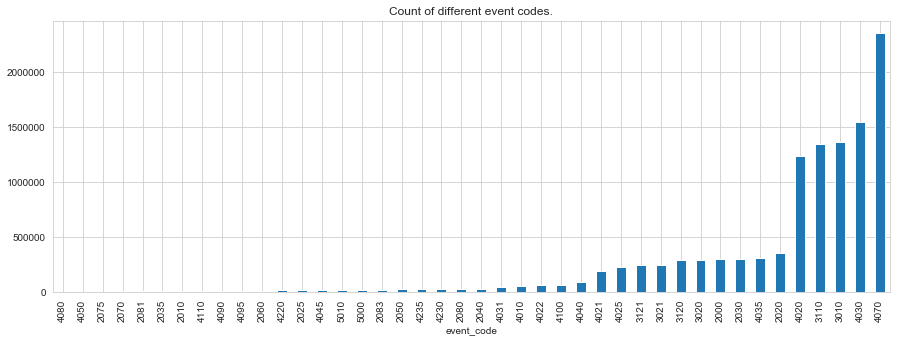

In [27]:
train.groupby('event_code') \
    .count()['event_id'] \
    .sort_values() \
    .plot(kind='bar',
         figsize=(15, 5),
         title='Count of different event codes.')
plt.show()

### `game_time`

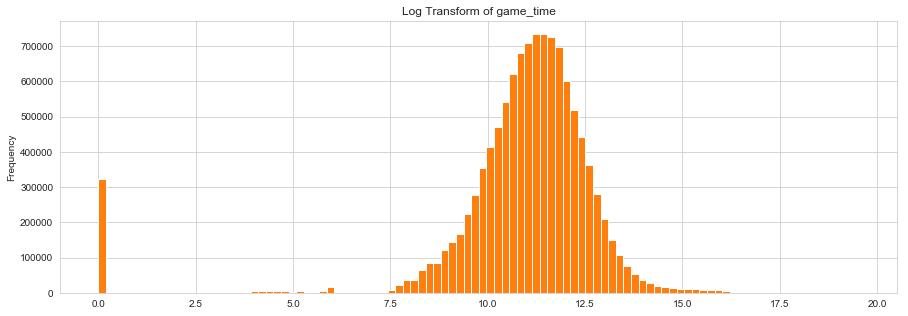

In [28]:
train['game_time'].apply(np.log1p) \
    .plot(kind='hist',
          figsize=(15, 5),
          bins=100,
          title='Log Transform of game_time',
          color=my_pal[1])
plt.show()

### `Game/Video titles`

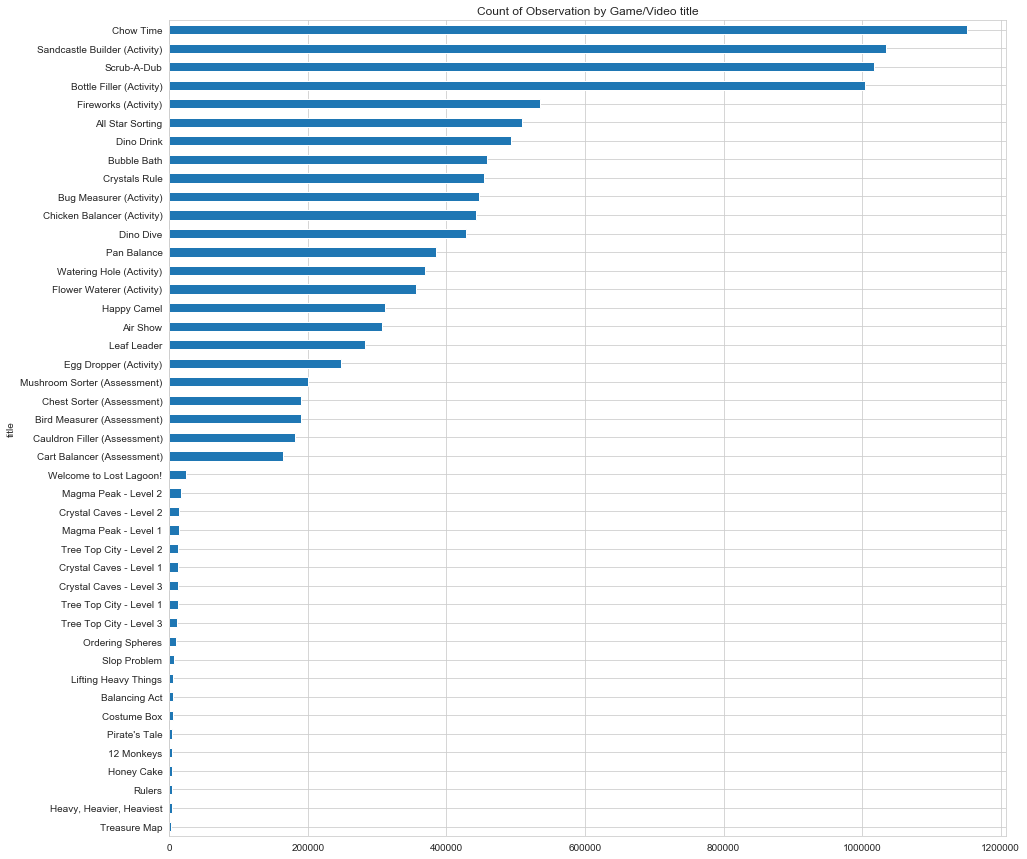

In [30]:
train.groupby('title')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='barh',
          title='Count of Observation by Game/Video title',
         figsize=(15, 15))
plt.show()

In [86]:
avg_time=[]
title_=[]
for i in train.title.unique():
    title_.append(i)
    avg_time.append(train.loc[train['title'] ==i]['game_time'].mean())
    
Avg_Timeplayed=pd.DataFrame()
Avg_Timeplayed['Title']=title_
Avg_Timeplayed['Average']=avg_time

fig = px.bar(Avg_Timeplayed, x='Title', y='Average',
             hover_data=['Average'], color='Average',
             labels={'pop':'Average time played on each titles'}, height=400)
fig.show()

### `Game/Video type`

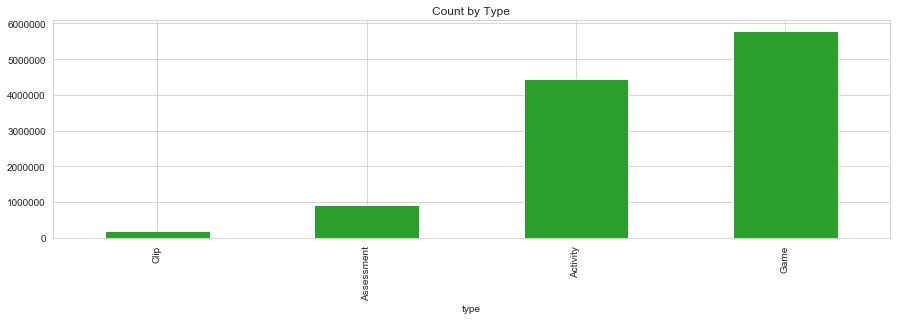

In [36]:
train.groupby('type')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='bar',
          figsize=(15, 4),
          title='Count by Type',
          color=my_pal[2])
plt.show()


In [78]:
avg_time=[]
type_=[]
for i in train.type.unique():
    type_.append(i)
    avg_time.append(train.loc[train['type'] ==i]['game_time'].mean())
    
Avg_Timeplayed=pd.DataFrame()
Avg_Timeplayed['Type']=type_
Avg_Timeplayed['Average']=avg_time

fig = px.bar(Avg_Timeplayed, x='Type', y='Average',
             hover_data=['Average'], color='Average',
             labels={'pop':'Average time played on each types'}, height=400)
fig.show()

### `World`

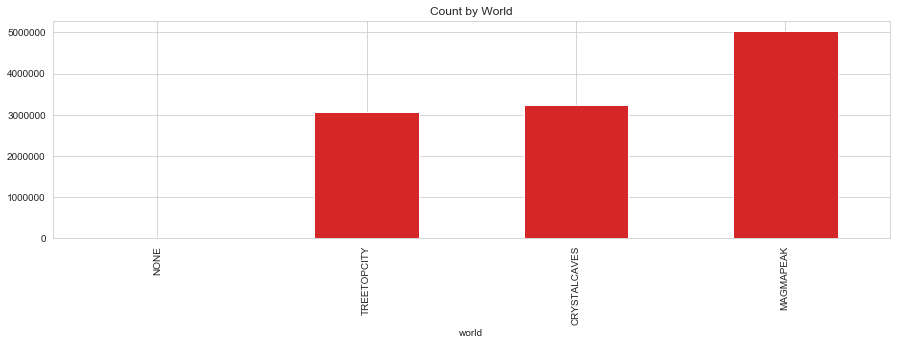

In [37]:
train.groupby('world')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='bar',
          figsize=(15, 4),
          title='Count by World',
          color=my_pal[3])
plt.show()

### `log(game_time) vs game/video categories`

In [39]:
train['log1p_game_time'] = train['game_time'].apply(np.log1p)

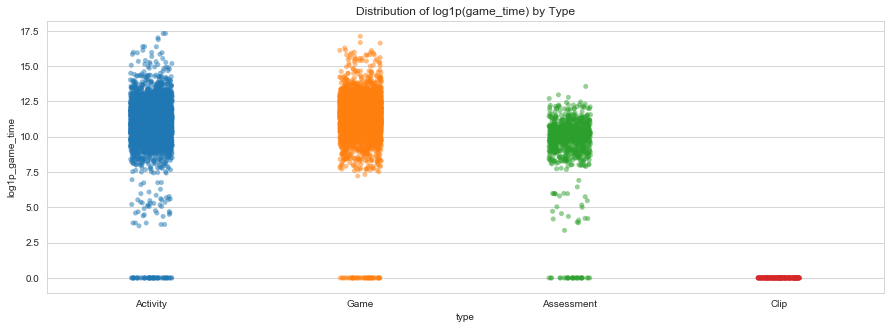

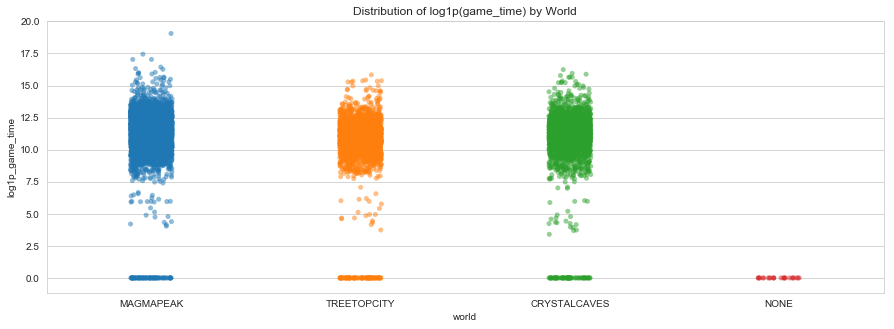

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.catplot(x="type", y="log1p_game_time",
            data=train.sample(10000), alpha=0.5, ax=ax);
ax.set_title('Distribution of log1p(game_time) by Type')
plt.close()
plt.show()
fig, ax = plt.subplots(figsize=(15, 5))
sns.catplot(x="world", y="log1p_game_time",
            data=train.sample(10000), alpha=0.5, ax=ax);
ax.set_title('Distribution of log1p(game_time) by World')
plt.close()
plt.show()

## Specs

In [41]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [42]:
specs.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,c74f40cd,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
freq,1,17,25


In [85]:
specs.args[0]

'[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"level","type":"int","info":"number of the current level when the event takes place or 0 if no level"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\\n\'audio\' || \'animation\' || \'other\'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]'

In [91]:
specs_args_extracted = pd.DataFrame()
for i in range(0, specs.shape[0]): 
    for arg_item in json.loads(specs.args[i]) :
        new_df = pd.DataFrame({'event_id': specs['event_id'][i],\
                               'info':specs['info'][i],\
                               'args_name': arg_item['name'],\
                               'args_type': arg_item['type'],\
                               'args_info': arg_item['info']}, index=[i])
        specs_args_extracted = specs_args_extracted.append(new_df)

In [92]:
specs_args_extracted.head(5)

,event_id,info,args_name,args_type,args_info
0,2b9272f4,The end of system-initiated feedback (Correct)...,game_time,int,millisecond count since start of game
0,2b9272f4,The end of system-initiated feedback (Correct)...,round,int,number of the current round when the event tak...
0,2b9272f4,The end of system-initiated feedback (Correct)...,level,int,number of the current level when the event tak...
0,2b9272f4,The end of system-initiated feedback (Correct)...,description,string,the text or description of the instruction
0,2b9272f4,The end of system-initiated feedback (Correct)...,identifier,string,a unique identifier for this piece of instruction


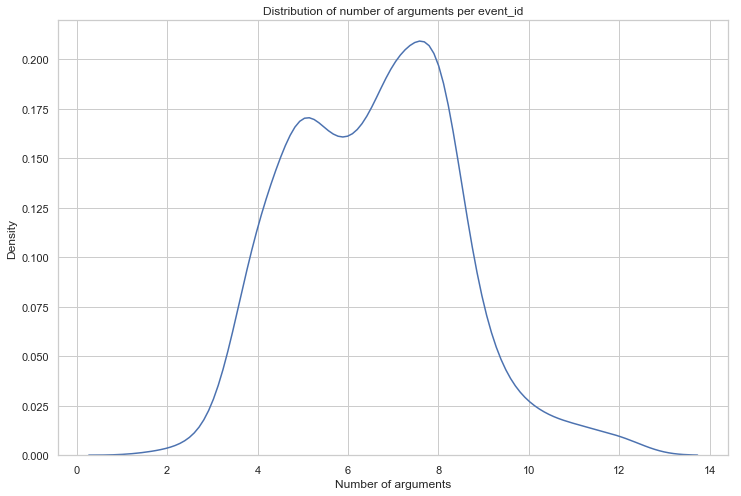

In [96]:
tmp = specs_args_extracted.groupby(['event_id'])['info'].count()
df = pd.DataFrame({'event_id':tmp.index, 'count': tmp.values})
plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
ax = sns.distplot(df['count'],kde=True,hist=False, bins=40)
plt.title('Distribution of number of arguments per event_id')
plt.xlabel('Number of arguments')
plt.ylabel('Density')
plt.show()

In [100]:
train_labels.shape

(17690, 7)

In [101]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [103]:
train_labels['installation_id'].nunique()

3614